In [1]:
%load_ext autoreload
%autoreload 2

In [807]:
import sys
sys.path.append('../')

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import torch
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

def generate_random_standard(n, m, device= "cpu"):
    array_2d = torch.zeros(n, n, dtype=torch.float32, device=device)
    for i in range(m):
        array_2d[n-i-2, n-1-i:]= 1
    for i in range(n-1-m):
        random_int = random.sample(range(i+1, n), m)
        array_2d[i, random_int]= 1
    return array_2d

def generate_spread_standard(n, m, device= "cpu"):
    array_2d = torch.zeros(n, n, dtype=torch.float32, device=device)
    for i in range(n-1):
        array_2d[i, i+1]= 1
        if i+m<n:
            array_2d[i, i+m]= 1
    return array_2d

def generate_cluster_standard(n, m, device= "cpu"):
    array_2d = torch.zeros(n, n, dtype=torch.float32, device=device)
    for i in range(n-1):
        array_2d[i, n-1]= 1
    return array_2d

def stanard(graph, node= 0, device= "cpu"):
    traversal = list(nx.dfs_preorder_nodes(graph, node))
    n= graph.number_of_nodes()
    lent= len(traversal)
    graphNew= torch.zeros(n, n, dtype=torch.float32, device=device)
    nameDic= {}
    for i in range(lent):
        orinInd= traversal[i]
        nameDic[orinInd]= i
        neighbors = set(graph.neighbors(orinInd))&set(traversal[0:i])
        values = [n-1-nameDic[key] for key in neighbors]
        graphNew[n-1-i, values]= 1
    return graphNew

def plot_tensor_graph(tensorG):
    graphNp= tensorG.cpu().detach().numpy()
    G= nx.Graph(graphNp)
    pos = nx.spring_layout(G)  # Positions of nodes for visualization
    nx.draw(G, pos, with_labels=True, node_color='lightblue', font_weight='bold')


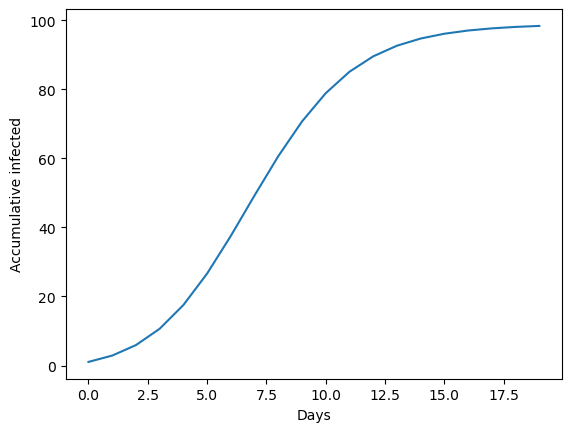

In [835]:
n= 100
m= 2
p= 0.15
firstIndex= n-1
timeHorizon= 20
dstGraph= generate_random_standard(n, m, device=device)
trainGraph= generate_spread_standard(n, m, device=device)
trainGraph= torch.nn.Parameter(trainGraph)
trainI= torch.zeros(n, 1, device=device)
trainS= torch.ones(n, 1, device=device)
trainI[firstIndex, 0]= 1
trainS[firstIndex, 0]= 0

def ICS_fun(C, I, S, p):
    ICS= 1-(C+C.T)*I*S.T*p
    deltaTensor= 1-torch.prod(ICS, dim=0)
    return deltaTensor[:, None]
tempI= trainI.clone()
tempS= trainS.clone()
addtiveNums= []
addtiveNum= 0
with torch.no_grad():
    for i in range(timeHorizon):
        deltaT= ICS_fun(dstGraph, tempI, tempS, p)
        tempI+= deltaT
        tempS-= deltaT
        addtiveNum+= deltaT.squeeze().sum()
        addtiveNums.append(addtiveNum.clone())
        pass
addtiveNums= torch.stack(addtiveNums)
plt.plot(addtiveNums.cpu().detach())
plt.xlabel("Days")
plt.ylabel("Accumulative infected")
losses= []

100%|██████████| 100/100 [00:07<00:00, 12.61it/s]


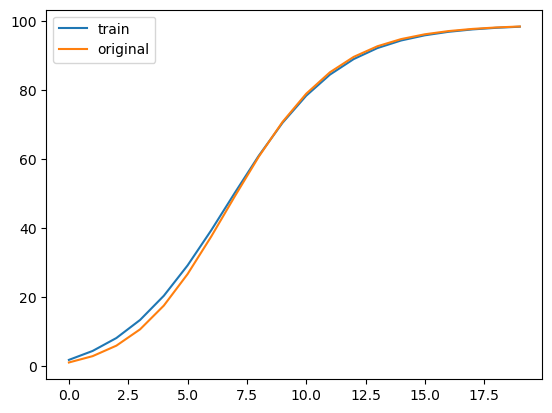

In [838]:
addtiveNums.requires_grad_(True)
for k in tqdm(range(100)):
    trainGraph.grad= None
    trainAddtiveNums= []
    trainAddtiveNum= 0
    trainIs= [trainI]
    trainSs= [trainS]
    lossFun= torch.nn.L1Loss(reduction='mean')
    for i in range(timeHorizon):
        deltaT= ICS_fun(trainGraph, trainIs[-1], trainSs[-1], p)
        trainIs.append(trainIs[-1]+ deltaT)
        trainSs.append(trainSs[-1]- deltaT)
        trainAddtiveNum+= deltaT.squeeze().sum()
        trainAddtiveNums.append(trainAddtiveNum.clone())
    trainAddtiveNums= torch.stack(trainAddtiveNums)
    loss= lossFun(trainAddtiveNums, addtiveNums)
    losses.append(loss.item())
    loss.backward(retain_graph=True)
    matrix = torch.ones(n, n, dtype= torch.float32, device= device)
    index= torch.zeros(n, device= device)
    maxBound= [n-i-2 for i in range(n)]
    maxBoundTen= torch.tensor(maxBound).cuda()
    delta= (mask*trainGraph.grad).sum(dim=1)
    for i in range(n):
        for j in range(i, n):
            if trainGraph[i, j]>0.1:
                index[i]= n-j-1
                trainGraph.data[i, j]= 0
                break
    # Create a lower triangle matrix
    mask = torch.triu(matrix, diagonal=1)
    lr= torch.abs(1/(delta.sum()/100)*50)
    if lr>5:
        lr= 5
    newIndex= torch.round(torch.relu(index+delta*lr/(index+0.5)))
    for i in range(len(newIndex)):
        if newIndex[i] > maxBoundTen[i]:
            newIndex[i] = maxBoundTen[i]
    for i in range(n):
        if newIndex[i]>-0.1:
            idx= int(newIndex[i].item())
            if trainGraph.data[i, n- idx- 1]>0.1:
                if n- idx- 2< 0:
                    trainGraph.data[i, n- idx]= 1
                else:
                    trainGraph.data[i, n- idx -2]= 1
            else:
                trainGraph.data[i, n- idx- 1]= 1

plt.plot(trainAddtiveNums.cpu().detach(), label="train")
plt.plot(addtiveNums.cpu().detach(), label= "original")
plt.legend()

In [839]:
print(trainGraph.sum(dim= 1))
print(lr)

tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 1., 0.], device='cuda:0',
       grad_fn=<SumBackward1>)
5


Text(0, 0.5, 'loss')

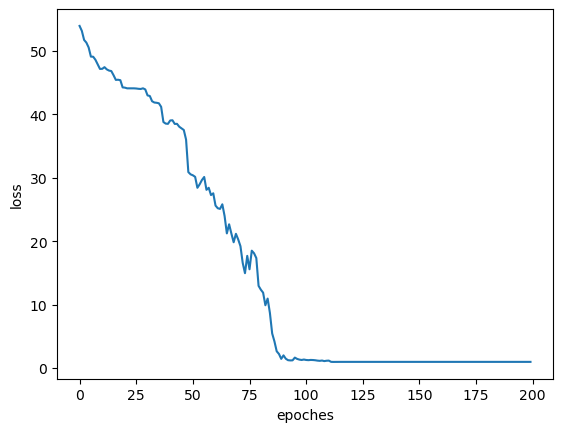

In [840]:
plt.plot(losses)
plt.xlabel("epoches")
plt.ylabel("loss")

In [193]:
matrix = torch.ones(n, n, dtype= torch.float32, device= device)
index= torch.zeros(n, device= device)
maxBound= [n-i-2 for i in range(n)]
maxBoundTen= torch.tensor(maxBound).cuda()
for i in range(n):
    for j in range(i, n):
        if trainGraph[i, j]>0:
            index[i]= n-j-1
            break
# Create a lower triangle matrix
mask = torch.triu(matrix, diagonal=1)
delta= (mask*trainGraph.grad).sum(dim=1)
newIndex= torch.round(torch.relu(index+delta*3e-2/(index+0.5)))
for i in range(len(newIndex)):
    if newIndex[i] > maxBoundTen[i]:
        newIndex[i] = maxBoundTen[i]
trainGraph.data= trainGraph.data*0
for i in range(n):
    if newIndex[i]>-0.1:
        idx= int(newIndex[i].item())
        trainGraph.data[i, n- idx- 2]= 1

In [139]:
n =400
def get_effct_matrix(n= 10, device= device):
    effectM= torch.zeros((n,n), device= device) 
    effectM[0, 0]= 1
    effectM[1, 1]= 1
    for i in range(2, n):
        for j in range(1, i+1):
            effectM[i, j]= effectM[0: i, j-1].sum()*1/i
    return effectM
timeAdd= [i for i in range(1, n+1)]
timeAdd= torch.Tensor(timeAdd).cuda()
timeAdd= timeAdd[None, :]
effectM= get_effct_matrix(n)
effecSum= (effectM*timeAdd).sum(dim= 1)
x= [i for i in range(0, n)]

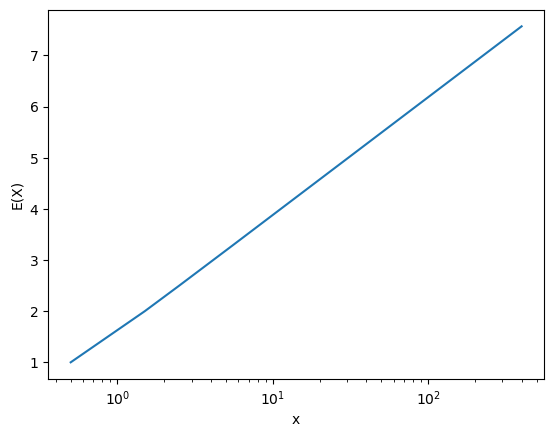

In [140]:
plt.plot(timeAdd[0].cpu().detach()-0.5, effecSum.cpu().detach())
plt.xlabel("x")
plt.ylabel("E(X)")
plt.xscale("log")

In [141]:
from scipy.optimize import curve_fit
xData= timeAdd[0].cpu().detach()-0.5
yData= effecSum.cpu().detach()
xData= xData.numpy()
yData= yData.numpy()
def model_function(x, a, b):
    return np.log(x) * a + b# e^x
params, covariance = curve_fit(model_function, xData, yData)
a_fit, b_fit = params
print(params)

[0.99796326 1.58776752]


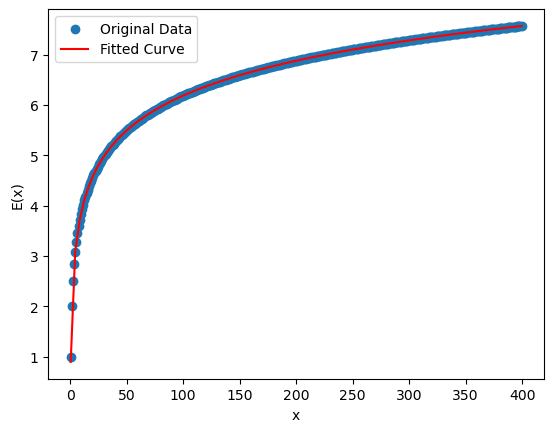

In [142]:
# Plot the original data
plt.scatter(xData, yData, label="Original Data")

# Generate x values for the fitted curve
x_fit = np.linspace(min(xData), max(xData), 100)

# Calculate the y values for the fitted curve using the fitted parameters
y_fit = model_function(x_fit, a_fit, b_fit)

# Plot the fitted curve
plt.plot(x_fit, y_fit, label="Fitted Curve", color='red')

plt.xlabel("x")
plt.ylabel("E(x)")
plt.legend()
plt.show()